<center>
    <img src="img/scikit-learn-logo.png" width="40%" />
    <br />
    <h1>An introduction to Machine Learning with Scikit-Learn</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>)
    <br /><br />
    New York University / CERN
</center>

## Prerequisites 

In [4]:
# This is an Jupyter notebook, with executable Python code inside
print("Hello world!")

Hello world!


- Materials available on  <a href="https://github.com/glouppe/tutorial-scikit-learn">GitHub</a>
    
- Require a Python distribution with scientific packages (NumPy, SciPy, Scikit-Learn, Pandas)

- See installation instructions in README

    

In [1]:
# Global imports and settings

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.max_open_warning"] = -1

# Print options
import numpy as np
np.set_printoptions(precision=3)

# Slideshow
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': 1440, 'height': 768, 'scroll': True, 'theme': 'simple'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [3]:
%%javascript
Reveal.addEventListener("slidechanged", function(event){ window.location.hash = "header"; });

<IPython.core.display.Javascript object>

# Outline

* Scikit-Learn and the scientific ecosystem in Python
* Classification
* Model evaluation and selection
* Transformers, pipelines and feature unions
* Beyond building classifiers
* Summary

# Scikit-Learn

## Overview

* Machine learning library written in __Python__
* __Simple and efficient__, for both experts and non-experts
* Classical, __well-established machine learning algorithms__
* Shipped with <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> and <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* __BSD 3 license__

## Community driven development

- 20~ core developers (mostly researchers)
- 500+ occasional contributors
- __All working publicly together__ on [GitHub](https://github.com/scikit-learn/scikit-learn)
- Emphasis on __keeping the project maintainable__
    - Style consistency
    - Unit-test coverage
    - Documentation and examples
    - Code review
- Join us!

## Python stack for data analysis

- The __open source__ Python ecosystem provides __a standalone, versatile and powerful scientific working environment__, including: [NumPy](http://numpy.org), [SciPy](http://scipy.org), [IPython](http://ipython.org), [Matplotlib](http://matplotlib.org), [Pandas](http://pandas.pydata.org/), _and many others..._

<center> 
<img src="img/scikit-learn-logo.png" style="max-width: 120px; display: inline" />
<img src="img/numpy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/scipy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/ipython-logo.jpg" style="max-width: 120px; display: inline" />
<img src="img/matplotlib-logo.png" style="max-width: 120px; display: inline"/>
<img src="img/pandas-logo.png" style="max-width: 120px; display: inline" />
</center>

- Scikit-Learn builds upon NumPy and SciPy and __complements__ this scientific environment with machine learning algorithms;
- By design, Scikit-Learn is __non-intrusive__, easy to use and easy to combine with other libraries;
- Core algorithms are implemented in low-level languages.

## Algorithms

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Support Vector Machines
* Tree-based methods (Random Forests, Bagging, GBRT, ...)
* Nearest neighbors
* Neural networks 
* Gaussian Processes
* Feature selection

__Unsupervised learning:__

* Clustering (KMeans, Ward, ...)
* Matrix decomposition (PCA, ICA, ...)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

_... and many more!_ (See our [Reference](http://scikit-learn.org/dev/modules/classes.html))

# Classification

## Framework

Data comes as a finite learning set ${\cal L} = (X, y)$ where
* Input samples are given as an array $X$ of shape `n_samples` $\times$ `n_features`, taking their values in ${\cal X}$;
* Output values are given as an array $y$, taking _symbolic_ values in ${\cal Y}$.

The goal of supervised classification is to build an estimator $\varphi_{\cal L}: {\cal X} \mapsto {\cal Y}$ minimizing

$$
Err(\varphi_{\cal L}) = \mathbb{E}_{X,Y}\{ L(Y, \varphi_{\cal L}(X)) \}
$$

where $L$ is a loss function, e.g., the zero-one loss for classification $L_{01}(Y,\hat{Y}) = 1(Y \neq \hat{Y})$.

## Applications

- Classifying signal from background events; 
- Diagnosing disease from symptoms;
- Recognising cats in pictures;
- Identifying body parts with Kinect cameras;
- ...
  

## Data 

- Input data = Numpy arrays or Scipy sparse matrices ;
- Algorithms are expressed using high-level operations defined on matrices or vectors (similar to MATLAB) ;
    - Leverage efficient low-leverage implementations ;
    - Keep code short and readable. 

In [5]:
# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))
print(X)
print(y[:5])

[[-6.453 -8.764]
 [ 0.29   0.147]
 [-5.184 -1.253]
 ..., 
 [-0.231 -1.608]
 [-0.603  6.873]
 [ 2.284  4.874]]
['r' 'r' 'b' 'r' 'b']


In [6]:
# X is a 2 dimensional array, with 1000 rows and 2 columns
print(X.shape)
 
# y is a vector of 1000 elements
print(y.shape)

(1000, 2)
(1000,)


In [7]:
# Rows and columns can be accessed with lists, slices or masks
print(X[[1, 2, 3]])     # rows 1, 2 and 3
print(X[:5])            # 5 first rows
print(X[500:510, 0])    # values from row 500 to row 510 at column 0
print(X[y == "b"][:5])  # 5 first rows for which y is "b"

[[ 0.29   0.147]
 [-5.184 -1.253]
 [-4.714  3.674]]
[[-6.453 -8.764]
 [ 0.29   0.147]
 [-5.184 -1.253]
 [-4.714  3.674]
 [ 4.516 -2.881]]
[-4.438 -2.46   4.331 -7.921  1.57   0.565  4.996  4.758 -1.604  1.101]
[[-5.184 -1.253]
 [ 4.516 -2.881]
 [ 1.708  2.624]
 [-0.526  8.96 ]
 [-1.076  9.787]]


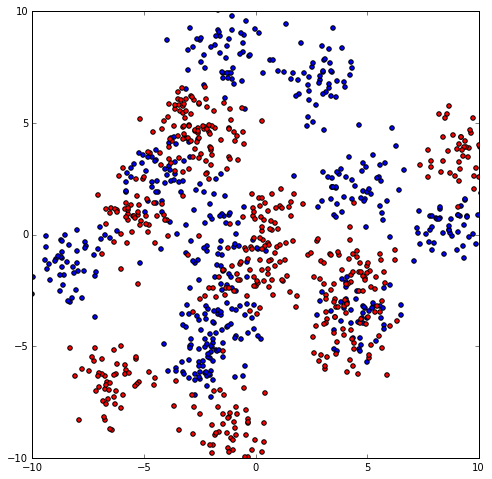

In [8]:
# Plot
plt.figure()
for label in labels:
    mask = (y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=label)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

## Loading external data

- Numpy provides some [simple tools](https://docs.scipy.org/doc/numpy/reference/routines.io.html) for loading data from files (CSV, binary, etc);

- For structured data, Pandas provides more [advanced tools](http://pandas.pydata.org/pandas-docs/stable/io.html) (CSV, JSON, Excel, HDF5, SQL, etc);

- For ROOT files, ``root_numpy`` provides loaders and converters to Numpy arrays.

In [ ]:
# this is a subset of the HIGGS dataset
# http://archive.ics.uci.edu/ml/datasets/HIGGS
import os 

if not os.path.exists('HIGGS_signal.root'):
    !wget http://files.figshare.com/1920200/HIGGS_signal.root
    !wget http://files.figshare.com/1920208/HIGGS_background.root

In [ ]:
from root_numpy import root2array, rec2array

# the first branch tells you the class of each sample, which is redundant here
signal = root2array("HIGGS_signal.root")
signal = rec2array(signal)[:, 1:]

backgr = root2array("HIGGS_background.root")
backgr = rec2array(backgr)[:, 1:]

# Organise data into one 2D array of shape (n_samples x n_features)
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]), 
                    np.zeros(backgr.shape[0])))

## A simple and unified API

All learning algorithms in scikit-learn share a uniform and limited API consisting of complementary interfaces:

- an `estimator` interface for building and fitting models;
- a `predictor` interface for making predictions;
- a `transformer` interface for converting data.

Goal: enforce a simple and consistent API to __make it trivial to swap or plug algorithms__. 

### Estimators

In [ ]:
class Estimator(object):
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self

In [9]:
# Import the nearest neighbor class
from sklearn.neighbors import KNeighborsClassifier  # Change this to try 
                                                    # something else

# Set hyper-parameters, for controlling algorithm
clf = KNeighborsClassifier(n_neighbors=5)

# Learn a model from training data
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [10]:
# Estimator state is stored in instance attributes
clf._tree

### Predictors

In [11]:
# Make predictions  
print(clf.predict(X[:5])) 

['r' 'r' 'r' 'b' 'b']


In [12]:
# Compute (approximate) class probabilities
print(clf.predict_proba(X[:5]))

[[ 0.   1. ]
 [ 0.   1. ]
 [ 0.2  0.8]
 [ 0.6  0.4]
 [ 0.8  0.2]]


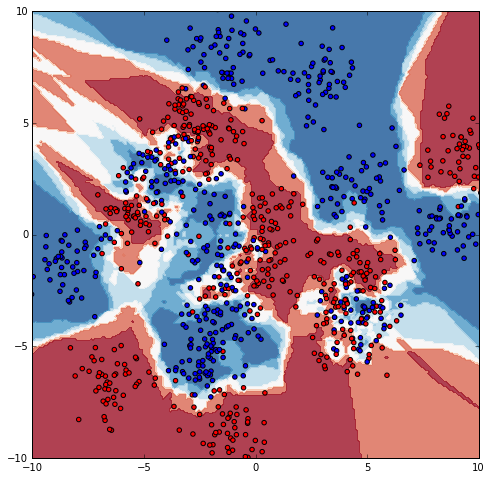

In [13]:
from tutorial import plot_surface    
plot_surface(clf, X, y)

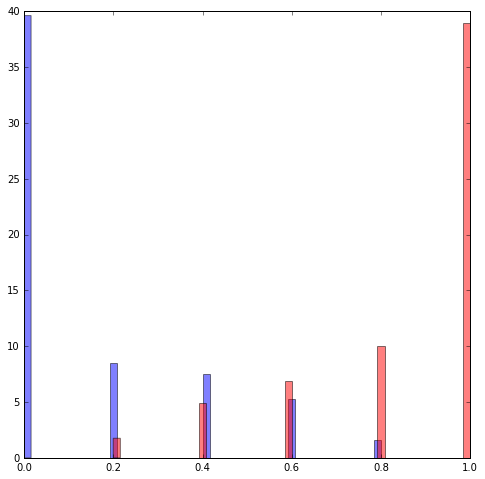

In [14]:
from tutorial import plot_histogram    
plot_histogram(clf, X, y)

## Classifier zoo

### Decision trees

Idea: greedily build a partition of the input space using cuts orthogonal to feature axes.

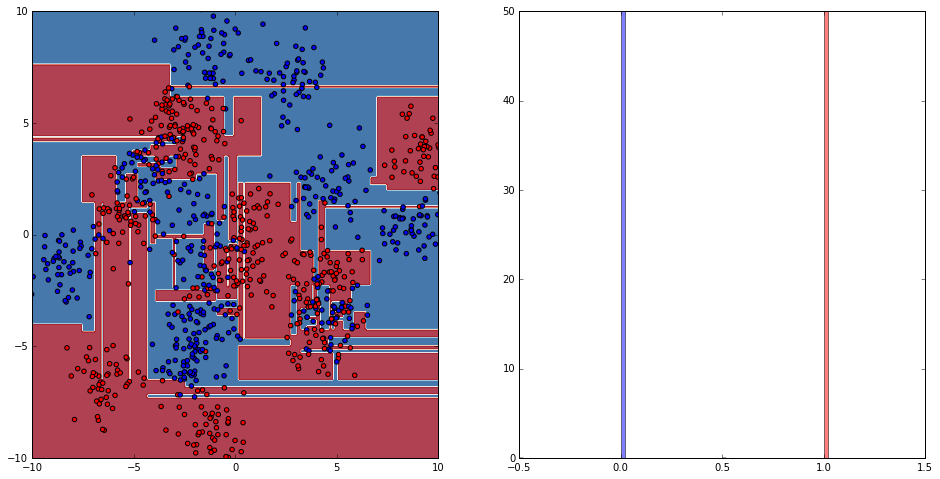

In [20]:
from tutorial import plot_clf
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier()
clf.fit(X, y)
plot_clf(clf, X, y)

### Random Forests

Idea: Build several decision trees with controlled randomness and average their decisions.

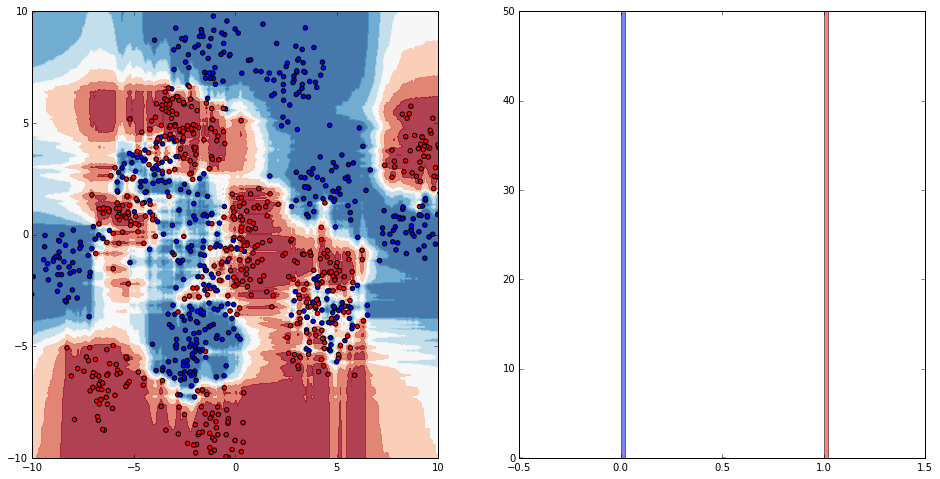

In [22]:
# from sklearn.ensemble import RandomForestClassifier 
# clf = RandomForestClassifier(n_estimators=500)
from sklearn.ensemble import ExtraTreesClassifier 
clf = ExtraTreesClassifier(n_estimators=500)
clf.fit(X, y)
plot_clf(clf, X, y)

### Support vector machines

Idea: Find the hyperplane which has the largest distance to the nearest training points of any class.

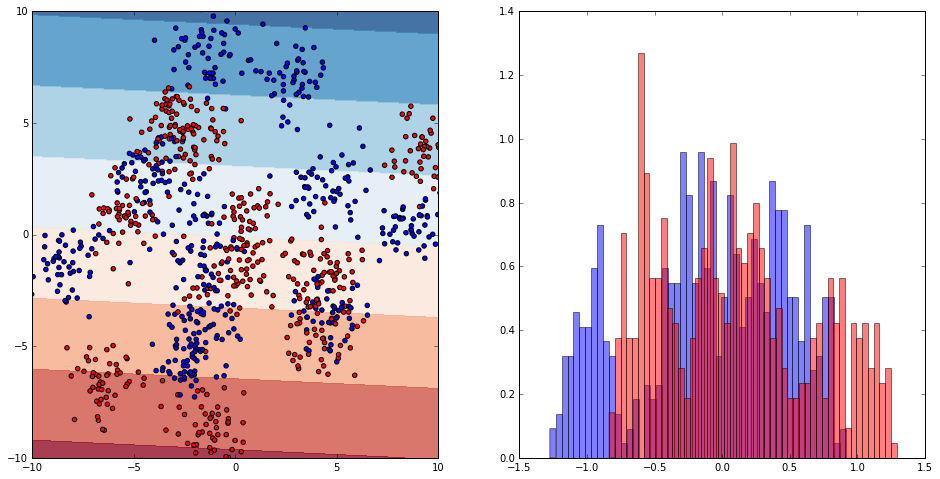

In [26]:
from sklearn.svm import SVC
clf = SVC(kernel="linear")  # try kernel="rbf" instead
clf.fit(X, y)
plot_clf(clf, X, y)

### Multi-layer perceptron

Idea: a multi-layer perceptron is a circuit of non-linear combinations of the data.

/home/gilles/src/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


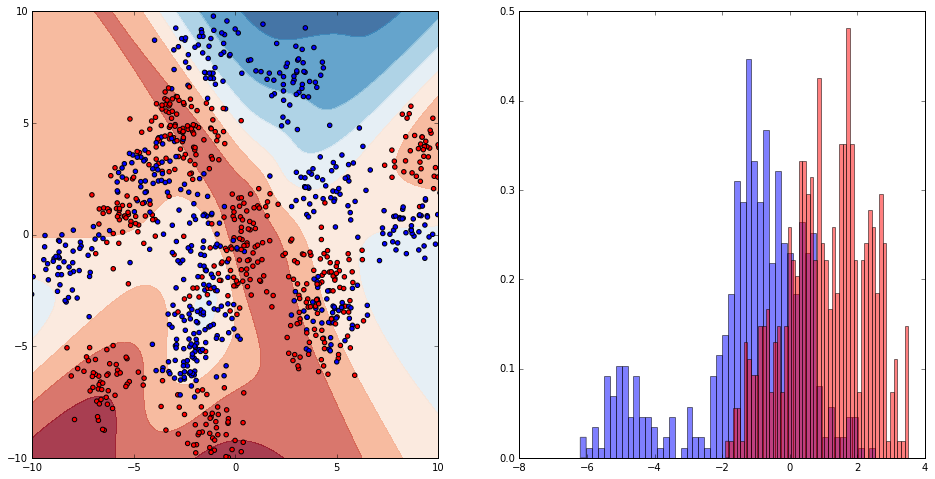

In [27]:
# Only scikit-learn 0.18
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation="tanh", learning_rate="invscaling")
clf.fit(X, y)
plot_clf(clf, X, y)

### Gaussian Processes

Idea: a gaussian process is a distribution over functions $f$, such that $f(\mathbf{x})$, for any set $\mathbf{x}$ of points, is gaussian distributed.

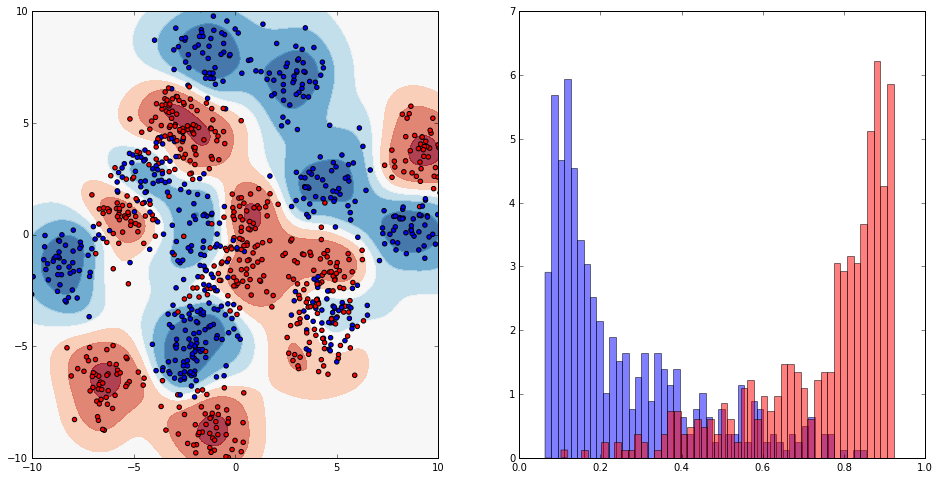

In [28]:
# Only scikit-learn 0.18
from sklearn.gaussian_process import GaussianProcessClassifier
clf = GaussianProcessClassifier()
clf.fit(X, y)
plot_clf(clf, X, y)         

# Model evaluation and selection

## Evaluation

- Recall that we want to learn an estimator $\varphi_{\cal L}$ minimizing the generalization error $Err(\varphi_{\cal L}) = \mathbb{E}_{X,Y}\{ L(Y, \varphi_{\cal L}(X)) \}$.

- Problem: Since $P_{X,Y}$ is unknown, the generalization error $Err(\varphi_{\cal L})$ cannot be evaluated.

- Solution: Use a proxy to approximate $Err(\varphi_{\cal L})$.

## Training error

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)
print("Training error =", zero_one_loss(y, clf.predict(X)))

Training error = 0.108


## Test error

Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide ${\cal L}$ into two disjoint parts called training and test sets (usually using 70% for training and 30% for test).
- Use the training set for fitting the model;
- Use the test set for evaluation only, thereby yielding an unbiased estimate.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

Training error = 0.109333333333
Test error = 0.14


Summary: Beware of bias when you estimate model performance:
- Training score is often an optimistic estimate of the true performance;
- __The same data should not be used both for training and evaluation.__

## Cross-validation

Issue: 
- When ${\cal L}$ is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set ${\cal L}$. 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error. 

Solution: K-Fold cross-validation. 
- Split ${\cal L}$ into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.

<center>![](img/cross-validation.png)</center>

In [31]:
from sklearn.model_selection import KFold

scores = []

for train, test in KFold(n_folds=5, random_state=42).split(X):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
    scores.append(zero_one_loss(y_test, clf.predict(X_test)))

print("CV error = %f +-%f" % (np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


In [32]:
# Shortcut
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y, 
                         cv=KFold(n_folds=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


## Metrics

### Default score

Estimators come with a built-in default evaluation score
* Accuracy for classification 
* R2 score for regression

In [33]:
y_train = (y_train == "r")
y_test = (y_test == "r")
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train) 
print("Default score =", clf.score(X_test, y_test))

Default score = 0.84


### Accuracy

Definition: The accuracy is the proportion of correct predictions.

In [34]:
from sklearn.metrics import accuracy_score
print("Accuracy =", accuracy_score(y_test, clf.predict(X_test)))

Accuracy = 0.84


### Precision, recall and F-measure

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F =", fbeta_score(y_test, clf.predict(X_test), beta=1))

### ROC AUC

Definition: Area under the curve of the false positive rate (FPR) against the true positive rate (TPR) as the decision threshold of the classifier is varied.

ROC AUC = 0.92977443609


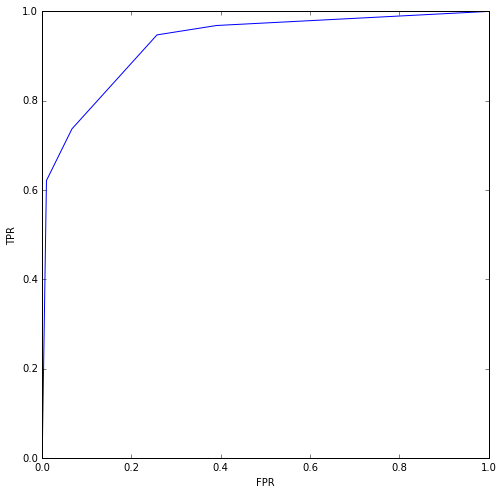

In [35]:
from sklearn.metrics import get_scorer
roc_auc_scorer = get_scorer("roc_auc")
print("ROC AUC =", roc_auc_scorer(clf, X_test, y_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Confusion matrix

Definition: number of samples of class $i$ predicted as class $j$.

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[86, 19],
       [13, 82]])

## Model selection
 
- Finding good hyper-parameters is crucial to control under- and over-fitting, hence achieving better performance.
- The estimated generalization error can be used to select the best model.

## Under- and over-fitting

- Under-fitting: the model is too simple and does not capture the true relation between X and Y.
- Over-fitting: the model is too specific to the training set and does not generalize.

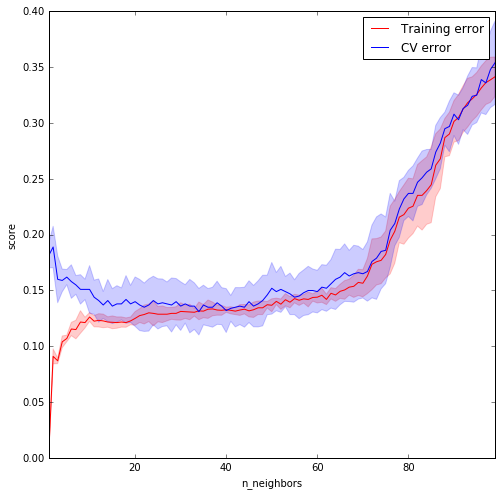

In [42]:
from sklearn.model_selection import validation_curve

# Evaluate parameter range in CV
param_range = range(1, 100)
param_name = "n_neighbors"

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), X, y, 
    param_name=param_name, 
    param_range=param_range, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot parameter VS estimated error
plt.xlabel(param_name)
plt.ylabel("score")
plt.xlim(min(param_range), max(param_range))
plt.plot(param_range, 1. - train_scores_mean, color="red", label="Training error")
plt.fill_between(param_range, 
                 1. - train_scores_mean + train_scores_std,
                 1. - train_scores_mean - train_scores_std,
                 alpha=0.2, color="red")
plt.plot(param_range, 1. - test_scores_mean, color="blue", label="CV error")
plt.fill_between(param_range, 
                 1. - test_scores_mean + test_scores_std,
                 1. - test_scores_mean - test_scores_std, 
                 alpha=0.2, color="blue")
plt.legend(loc="best")

In [43]:
# Best trade-off
print("%s = %d, CV error = %f" % (param_name,
                                  param_range[np.argmax(test_scores_mean)],
                                  1. - np.max(test_scores_mean)))

n_neighbors = 34, CV error = 0.131000


Question: Where is the model under-fitting and over-fitting?

Question: What does it mean if the training error is different from the test error?

## Hyper-parameter search

In [44]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid={"n_neighbors": list(range(1, 100))},
                    scoring="accuracy",
                    cv=5, n_jobs=-1)
grid.fit(X, y)  # Note that GridSearchCV is itself an estimator

print("Best score = %f, Best parameters = %s" % (1. - grid.best_score_, 
                                                 grid.best_params_))

Best score = 0.131000, Best parameters = {'n_neighbors': 34}


Question: Should you report the best score as an estimate of the generalization error of the model?

## Selection and evaluation, _simultaneously_

- `grid.best_score_` is not independent from the best model, since its construction was guided by the optimization of this quantity. 

- As a result, the optimized `grid.best_score_` estimate _may_ in fact be a biased, optimistic, estimate of the true performance of the model. 

- Solution: Use __nested__ cross-validation for correctly selecting the model __and__ correctly evaluating its performance. 

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

scores = cross_val_score(
            GridSearchCV(KNeighborsClassifier(),
                         param_grid={"n_neighbors": list(range(1, 100))},
                         scoring="accuracy",
                         cv=5, n_jobs=-1), 
            X, y, cv=5, scoring="accuracy")

# Unbiased estimate of the accuracy
print("%f +-%f" % (1. - np.mean(scores), np.std(scores)))

0.144000 +-0.023958


In [ ]:
while True:
    break

# Transformers, pipelines and feature unions

## Transformers

- Classification (or regression) is often only one or the last step of a long and complicated process;
- In most cases, input data needs to be cleaned, massaged or extended before being fed to a learning algorithm;
- For this purpose, Scikit-Learn provides the ``transformer`` API.

In [ ]:
class Transformer(object):    
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
    
    def transform(self, X):
        """Transform X into Xt."""
        # transform X in some way to produce Xt
        return Xt
    
    # Shortcut
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        Xt = self.transform(X)
        return Xt

## Transformer zoo

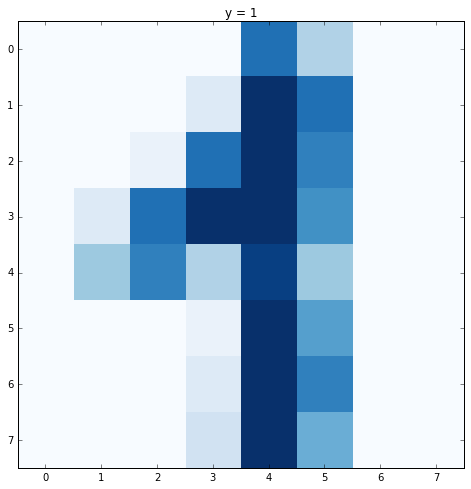

In [46]:
# Load digits data
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Plot
sample_id = 42
plt.imshow(X[sample_id].reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.title("y = %d" % y[sample_id])
plt.show()

### Scalers and other normalizers

In [47]:
from sklearn.preprocessing import StandardScaler
tf = StandardScaler()
tf.fit(X_train, y_train)
Xt_train = tf.transform(X)  
print("Mean (before scaling) =", np.mean(X_train))
print("Mean (after scaling) =", np.mean(Xt_train))

# Shortcut: Xt = tf.fit_transform(X)
# See also Binarizer, MinMaxScaler, Normalizer, ...

Mean (before scaling) = 4.89212138085
Mean (after scaling) = -0.00020489073799


In [48]:
# Scaling is critical for some algorithms
from sklearn.svm import SVC
clf = SVC()
print("Without scaling =", clf.fit(X_train, y_train).score(X_test, y_test))
print("With scaling =", clf.fit(tf.transform(X_train), y_train).score(tf.transform(X_test), y_test))

Without scaling = 0.486666666667
With scaling = 0.984444444444


### Feature selection

Shape = (1347, 10)


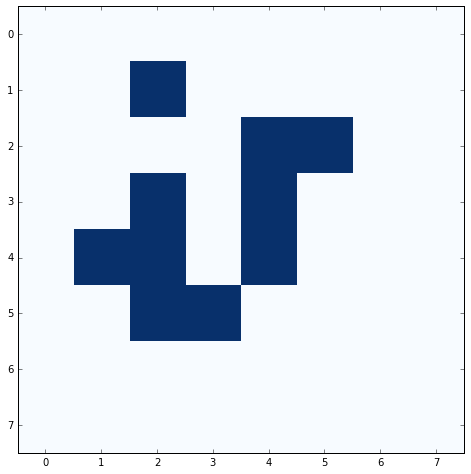

In [49]:
# Select the 10 top features, as ranked using ANOVA F-score
from sklearn.feature_selection import SelectKBest, f_classif
tf = SelectKBest(score_func=f_classif, k=10)
Xt = tf.fit_transform(X_train, y_train)
print("Shape =", Xt.shape)

# Plot support
plt.imshow(tf.get_support().reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.show()

### Feature selection (cont.)

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

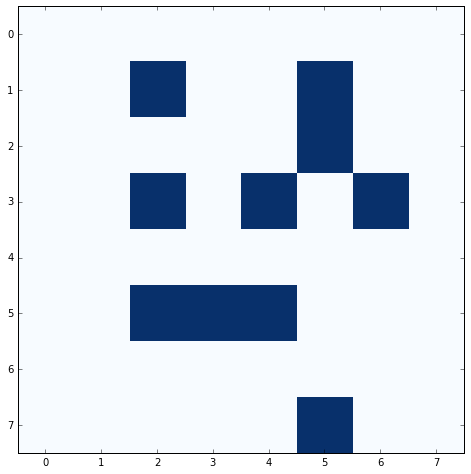

In [50]:
# Feature selection using backward elimination
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
tf = RFE(RandomForestClassifier(), n_features_to_select=10, verbose=1)
Xt = tf.fit_transform(X_train, y_train)
print("Shape =", Xt.shape)

# Plot support
plt.imshow(tf.get_support().reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.show()

### Decomposition, factorization or embeddings

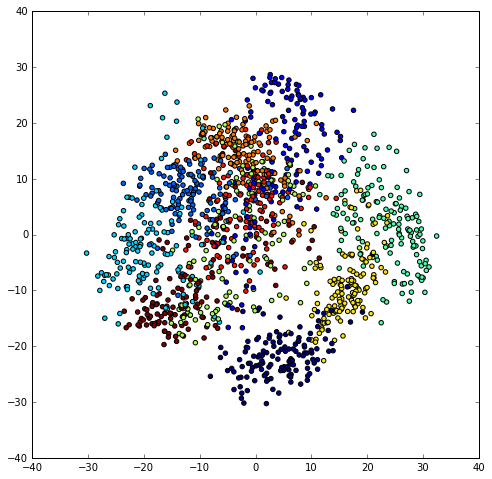

In [54]:
# Compute decomposition
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
tf = PCA(n_components=2)
Xt_train = tf.fit_transform(X_train)

# Plot
plt.scatter(Xt_train[:, 0], Xt_train[:, 1], c=y_train)
plt.show()

# See also: KernelPCA, NMF, FastICA, Kernel approximations, 
#           manifold learning, etc

### Function transformer

In [55]:
from sklearn.preprocessing import FunctionTransformer

def increment(X):
    return X + 1

tf = FunctionTransformer(func=increment)
Xt = tf.fit_transform(X)
print(X[0])
print(Xt[0])

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]
[  1.   1.   6.  14.  10.   2.   1.   1.   1.   1.  14.  16.  11.  16.   6.
   1.   1.   4.  16.   3.   1.  12.   9.   1.   1.   5.  13.   1.   1.   9.
   9.   1.   1.   6.   9.   1.   1.  10.   9.   1.   1.   5.  12.   1.   2.
  13.   8.   1.   1.   3.  15.   6.  11.  13.   1.   1.   1.   1.   7.  14.
  11.   1.   1.   1.]


## Pipelines

Transformers can be chained in sequence to form a pipeline.

In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Chain transformers to build a new transformer
tf = make_pipeline(StandardScaler(), 
                   SelectKBest(score_func=f_classif, k=10))
tf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7ff6a1780ea0>))])

In [57]:
Xt_train = tf.transform(X_train)
print("Mean =", np.mean(Xt_train))
print("Shape =", Xt_train.shape)

Mean = -1.37150045507e-17
Shape = (1347, 10)


In [58]:
# Chain transformers + a classifier to build a new classifier
clf = make_pipeline(StandardScaler(), 
                    SelectKBest(score_func=f_classif, k=10), 
                    RandomForestClassifier())
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test)[:5])

[[ 0.   0.   0.8  0.1  0.   0.   0.   0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.1  0.8  0.1  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]]


In [60]:
# Hyper-parameters can be accessed using step names
print("K =", clf.get_params()["selectkbest__k"])

K = 10


In [61]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(clf, 
                    param_grid={"selectkbest__k": [1, 10, 20, 30, 40, 50],
                                "randomforestclassifier__max_features": [0.1, 0.25, 0.5]})
grid.fit(X_train, y_train)

print("Best params =", grid.best_params_)

Best params = {'selectkbest__k': 50, 'randomforestclassifier__max_features': 0.25}


## Feature unions

Similarly, transformers can be applied in parallel to transform data in union.

In [62]:
from sklearn.pipeline import make_union
from sklearn.decomposition import PCA, FastICA
tf = make_union(PCA(n_components=10), FastICA(n_components=10))
Xt_train = tf.fit_transform(X_train)
print("Shape =", Xt_train.shape)

Shape = (1347, 20)


## Nested composition

Since pipelines and unions are themselves estimators, they can be composed into nested structures.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

clf = make_pipeline(
    # Build features
    make_union(
        FunctionTransformer(func=lambda X: X), # Identity
        PCA(),
    ), 
    # Select the best features
    RFE(RandomForestClassifier(), n_features_to_select=10),
    # Train
    MLPClassifier()
)

clf.fit(X_train, y_train)

# Beyond building classifiers

- (Quantile) Regression
- Clustering
- Density estimation
- Feature learning
- Outlier detection
- ...

## Example: Kernel Density estimation

In [65]:
# Load the data
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data

In [66]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
X = pca.fit_transform(X)

# Use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 100)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X)

print("Best bandwidth: %.2f" % grid.best_estimator_.bandwidth)

Best bandwidth: 3.59


In [67]:
# Use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# Sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

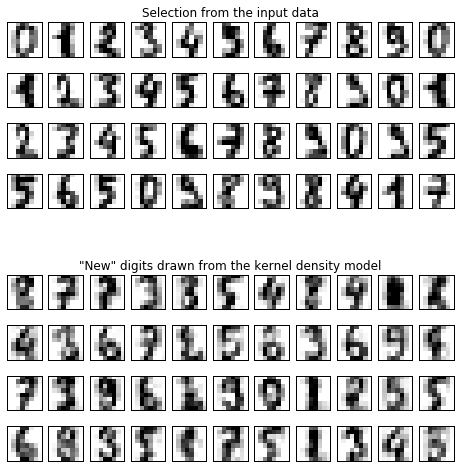

In [68]:
# Turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# Plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')
plt.show()

# Summary

- Scikit-Learn provides essential tools for machine learning. 
- It is more than training classifiers!
- It integrates within a larger Python scientific ecosystem.
- Try it for yourself!

In [ ]:
questions?